<a href="https://colab.research.google.com/github/Txlu-OG/Learn/blob/main/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Assignment Natural Language processsing - Sentiment Analysis**

### **Customer Review Classification using Random Forest**

- Dataset consists of 3000 Amazon customer reviews, star ratings, date of review, variant and feedback of various amazon Alexa products like Alexa Echo, Echo dots.
- **The objective is to discover insights into consumer reviews and perfrom sentiment analysis on the data.** Positive or Negative review?
- Dataset: www.kaggle.com/sid321axn/amazon-alexa-reviews also provided(`amazon_alexa.tsv`)
---




### **Follow the instructions and complete each TODO to complete the assessment on the essential steps in building and evaluating a classification model.**



**Dataset Information:**

The dataset consists of customer reviews for Amazon Alexa products, including various features related to the product variation, customer rating, and feedback sentiment.

_Features/Columns_:
* rating: The customer rating of the product (scale of 1 to 5).
* date: The date when the review was posted.
* variation: The variation or type of Alexa product the review is for (e.g., "Charcoal Fabric", "Walnut Finish").
* verified_reviews: The actual review text written by the customer.
* feedback: The target variable indicating the sentiment of the review (1 for positive sentiment and 0 for negative sentiment).



---




In [ ]:
# Amazon Alexa Customer Review Sentiment Analysis
# Objective: Classify reviews as positive or negative using Random Forest
# TODO: Import necessary libraries
# Hint: You'll need pandas, numpy, matplotlib, seaborn, and various sklearn modules
!pip -q install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install -U transformers accelerate scikit-learn seaborn matplotlib packaging

import warnings, inspect
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
)
from sklearn.decomposition import PCA

import torch
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from packaging import version
import transformers as _tf

sns.set(style="whitegrid", rc={"figure.figsize": (8,5)})
RANDOM_STATE = 42

print("Transformers version:", _tf.__version__)

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# TODO: Load the dataset
# Hint: Use pandas to read the CSV file from your Google Drive
PATH = "/content/drive/My Drive/amazon_alexa.tsv"

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

try:
    df = pd.read_csv(
        PATH,
        sep="\t",
        engine="c",
        encoding="utf-8",
        quoting=csv.QUOTE_MINIMAL,
        on_bad_lines="error"
    )
except Exception as e1:
    print("C engine failed, retrying with python engine:", e1)
    df = pd.read_csv(
        PATH,
        sep="\t",
        engine="python",
        encoding="utf-8",
        quoting=csv.QUOTE_MINIMAL,
        on_bad_lines="warn"
    )

print(df.head())
print(df.info())
print(df.describe(include="all"))

# Data Visualization and Clean Up
# TODO: Visualize the distribution of feedback
# Hint: Use seaborn's countplot function

sns.countplot(x="feedback", data=df)
plt.title("Feedback class distribution")
plt.show()

if "variation" in df.columns and "rating" in df.columns:
    plt.figure(figsize=(10,4))
    sns.barplot(x="variation", y="rating", data=df, estimator=np.mean, errorbar=None)
    plt.xticks(rotation=45, ha="right")
    plt.title("Variation vs Rating (mean)")
    plt.tight_layout()
    plt.show()

# TODO: Visualize the relationship between variations and ratings
# Hint: Use seaborn's barplot function

# TODO: Drop irrelevant columns
# Hint: Use the drop() method to remove 'date' and 'rating' columns
# Drop 'date' and 'rating'
for col in ["date", "rating"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Missing values
df["verified_reviews"] = df["verified_reviews"].fillna("")
if df["feedback"].isna().any():
    df["feedback"] = df["feedback"].fillna(df["feedback"].mode()[0])
df["feedback"] = df["feedback"].astype(int)

# One-Hot Encoding
# TODO: Perform one-hot encoding on the 'variation' column
# Hint: Use pandas get_dummies() function
# One-hot encode 'variation'
if "variation" in df.columns:
    df = pd.get_dummies(df, columns=["variation"])

# Tokenization (Count Vectorizer)
# TODO: Tokenize the 'verified_reviews' column
# Hint: Use CountVectorizer from sklearn.feature_extraction.text
# Feature engineering: BoW and TF-IDF, plus PCA visualization
bow_vectorizer = CountVectorizer(max_features=2000, stop_words="english")
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words="english")

X_bow = bow_vectorizer.fit_transform(df["verified_reviews"])
X_tfidf = tfidf_vectorizer.fit_transform(df["verified_reviews"])

# PCA visualization on TF-IDF
pca = PCA(n_components=2, random_state=RANDOM_STATE)
plot_idx = np.random.RandomState(RANDOM_STATE).choice(
    np.arange(X_tfidf.shape[0]),
    size=min(1500, X_tfidf.shape[0]),
    replace=False
)
X_tfidf_pca = pca.fit_transform(X_tfidf[plot_idx].toarray())
sns.scatterplot(
    x=X_tfidf_pca[:,0],
    y=X_tfidf_pca[:,1],
    hue=df["feedback"].iloc[plot_idx].astype(str),
    palette="Set1",
    s=20
)
plt.title("TF-IDF embeddings (PCA)")
plt.legend(title="feedback")
plt.show()

# TODO: Combine tokenized reviews with the main dataframe
# Hint: Use pd.concat() to join the dataframes

# Prepare data for modeling
# TODO: Split the data into features (X) and target (y)
# Hint: The target variable is 'feedback'
# Combine TF-IDF with any one-hot columns
other_cols = [c for c in df.columns if c.startswith("variation_")]
X_other = df[other_cols].values if other_cols else None
X = np.concatenate([X_tfidf.toarray(), X_other], axis=1) if X_other is not None else X_tfidf.toarray()
y = df["feedback"].values

# TODO: Split the data into training and testing sets
# Hint: Use train_test_split from sklearn.model_selection
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Train the Random Forest model
# TODO: Create and train the Random Forest model
# Hint: Use RandomForestClassifier from sklearn.ensemble
# Traditional models and tuning
# Logistic Regression
logreg = LogisticRegression(max_iter=2000, solver="liblinear", random_state=RANDOM_STATE)
logreg_cv = GridSearchCV(
    logreg, {"C":[0.1, 0.5, 1, 2, 5]},
    cv=3, n_jobs=-1, scoring="f1"
)
logreg_cv.fit(X_train, y_train)
logreg_best = logreg_cv.best_estimator_
print("Best LogReg params:", logreg_cv.best_params_)

# Random Forest
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_cv = GridSearchCV(
    rf,
    {"n_estimators":[100, 200], "max_depth":[None, 10, 20]},
    cv=3, n_jobs=-1, scoring="f1"
)
rf_cv.fit(X_train, y_train)
rf_best = rf_cv.best_estimator_
print("Best RF params:", rf_cv.best_params_)

# Evaluate the model
# TODO: Generate predictions and create confusion matrix
# Hint: Use the predict() method and confusion_matrix from sklearn.metrics
# Evaluate traditional models
def evaluate_model(model, Xtr, ytr, Xte, yte, name="model"):
    print(f"\n{name} - Accuracy")
    print(f"Train: {model.score(Xtr, ytr):.4f}")
    print(f"Test : {model.score(Xte, yte):.4f}")

    y_pred = model.predict(Xte)
    print(f"\n{name} - Classification report (test)")
    print(classification_report(yte, y_pred, digits=4))

    cm = confusion_matrix(yte, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix (Test)")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

    scores = None
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(Xte)

    if scores is not None:
        fpr, tpr, _ = roc_curve(yte, scores)
        auc_val = roc_auc_score(yte, scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
        plt.plot([0,1],[0,1],"k--")
        plt.title("ROC Curve (Test)")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

evaluate_model(logreg_best, X_train, y_train, X_test, y_test, "Logistic Regression (TF-IDF)")
evaluate_model(rf_best,    X_train, y_train, X_test, y_test, "Random Forest (TF-IDF + dummies)")

# TODO: Plot confusion matrix
# Hint: Use seaborn's heatmap function

# TODO: Print classification report
# Hint: Use classification_report from sklearn.metrics

# Feature Importance
# TODO: Visualize feature importance
# Hint: Access feature_importances_ attribute of the trained model
# Random Forest feature importances
importances = rf_best.feature_importances_
feature_names = list(tfidf_vectorizer.get_feature_names_out()) + (other_cols if other_cols else [])
idx = np.argsort(importances)[-20:]
plt.barh(np.array(feature_names)[idx], importances[idx])
plt.title("Random Forest - Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# Predict helper
def predict_sentiment(text: str) -> int:
    vec = tfidf_vectorizer.transform([text]).toarray()
    if X_other is not None:
        other_zeros = np.zeros((1, X_other.shape[1]))
        feat = np.concatenate([vec, other_zeros], axis=1)
    else:
        feat = vec
    return int(rf_best.predict(feat)[0])

print("Sample prediction:", predict_sentiment("I love my Alexa device, it is very helpful."))

# TODO: Make predictions on new data
# Hint: Create a function that takes a new review text, preprocesses it,
# and uses the trained model to predict its sentiment
# BERT with PyTorch Trainer (version-agnostic TrainingArguments)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch device:", device)

texts  = df["verified_reviews"].astype(str).tolist()
labels = df["feedback"].astype(int).tolist()

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    texts, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 128
train_enc = tokenizer(X_train_b, truncation=True, padding=True, max_length=MAX_LEN)
test_enc  = tokenizer(X_test_b,  truncation=True, padding=True, max_length=MAX_LEN)

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = SimpleDataset(train_enc, y_train_b)
test_ds  = SimpleDataset(test_enc,  y_test_b)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Build TrainingArguments only with supported args in your version
sig = inspect.signature(TrainingArguments.__init__).parameters
ta_kwargs = dict(output_dir="./bert_out")

# Safe, widely-supported args
if "learning_rate" in sig:                    ta_kwargs["learning_rate"] = 2e-5
if "per_device_train_batch_size" in sig:      ta_kwargs["per_device_train_batch_size"] = 16
if "per_device_eval_batch_size" in sig:       ta_kwargs["per_device_eval_batch_size"] = 32
if "num_train_epochs" in sig:                 ta_kwargs["num_train_epochs"] = 2
if "weight_decay" in sig:                     ta_kwargs["weight_decay"] = 0.01
if "logging_steps" in sig:                    ta_kwargs["logging_steps"] = 100
if "seed" in sig:                             ta_kwargs["seed"] = RANDOM_STATE
if "fp16" in sig:                             ta_kwargs["fp16"] = torch.cuda.is_available()
training_args = TrainingArguments(**ta_kwargs)

from sklearn.metrics import precision_recall_fscore_support
def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_hat = np.argmax(logits, axis=1)
    acc = accuracy_score(y_true, y_hat)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
    try:
        probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
        roc = roc_auc_score(y_true, probs)
    except Exception:
        roc = float("nan")
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1, "roc_auc": roc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate after training
bert_metrics = trainer.evaluate()
print("BERT eval metrics:", bert_metrics)

# BERT predictions and plots
pred = trainer.predict(test_ds)
logits = pred.predictions
y_true = np.array(y_test_b)
y_hat  = np.argmax(logits, axis=1)
probs  = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]

print("\nBERT classification report (test):")
print(classification_report(y_true, y_hat, digits=4))

cm = confusion_matrix(y_true, y_hat)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("BERT (PyTorch) - Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

fpr, tpr, _ = roc_curve(y_true, probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, probs):.3f}")
plt.plot([0,1],[0,1], "--")
plt.title("BERT (PyTorch) - ROC Curve (Test)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Example usage of your prediction function:
# new_review = "I love my Alexa device! It's so helpful."
# predicted_sentiment = predict_sentiment(new_review)
# print(f"The sentiment of the new review is: {predicted_sentiment}")

Transformers version: 4.57.1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 

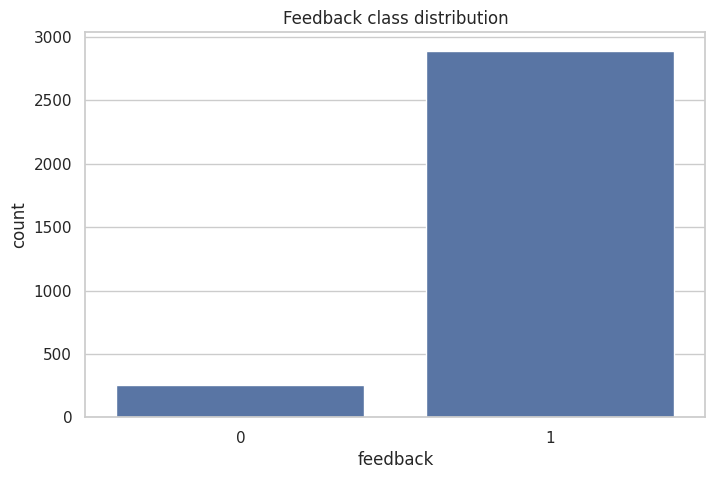

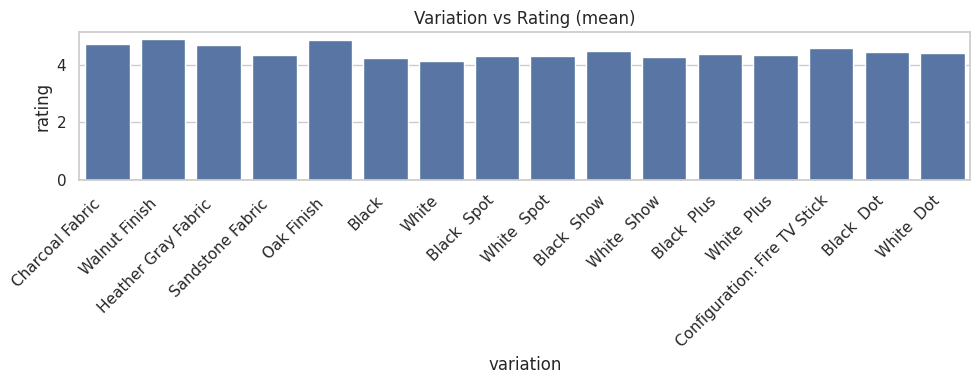

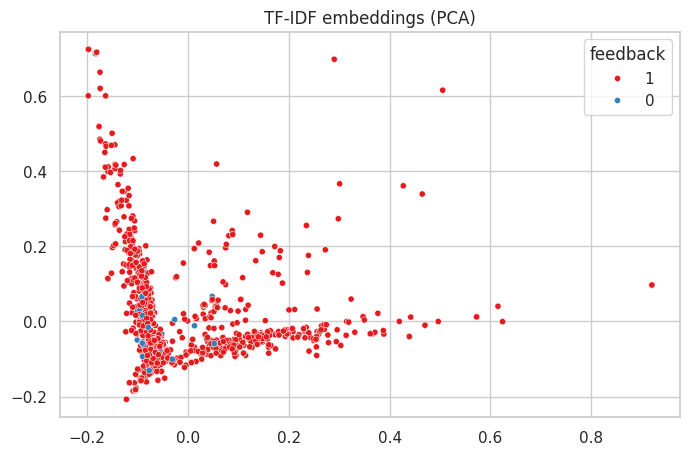

Best LogReg params: {'C': 5}
Best RF params: {'max_depth': None, 'n_estimators': 100}

Logistic Regression (TF-IDF) - Accuracy
Train: 0.9790
Test : 0.9254

Logistic Regression (TF-IDF) - Classification report (test)
              precision    recall  f1-score   support

           0     0.6429    0.1765    0.2769        51
           1     0.9318    0.9914    0.9607       579

    accuracy                         0.9254       630
   macro avg     0.7873    0.5839    0.6188       630
weighted avg     0.9084    0.9254    0.9053       630



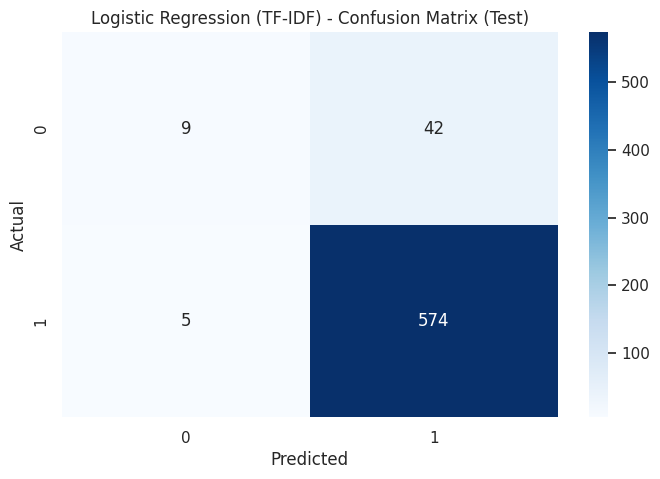

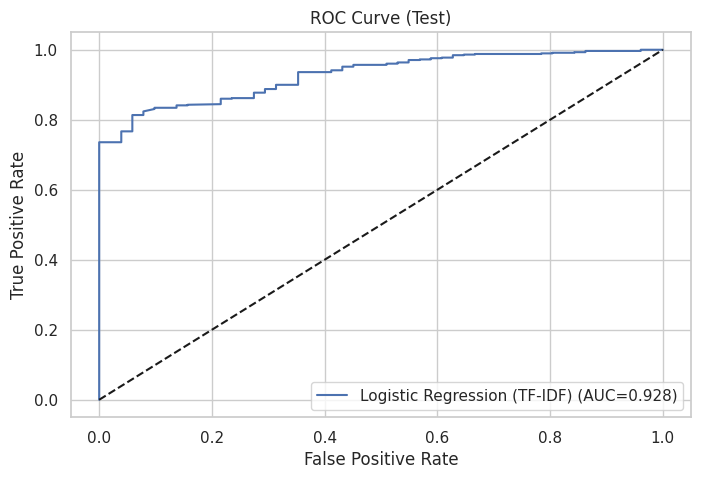


Random Forest (TF-IDF + dummies) - Accuracy
Train: 0.9948
Test : 0.9286

Random Forest (TF-IDF + dummies) - Classification report (test)
              precision    recall  f1-score   support

           0     0.7143    0.1961    0.3077        51
           1     0.9334    0.9931    0.9623       579

    accuracy                         0.9286       630
   macro avg     0.8239    0.5946    0.6350       630
weighted avg     0.9157    0.9286    0.9093       630



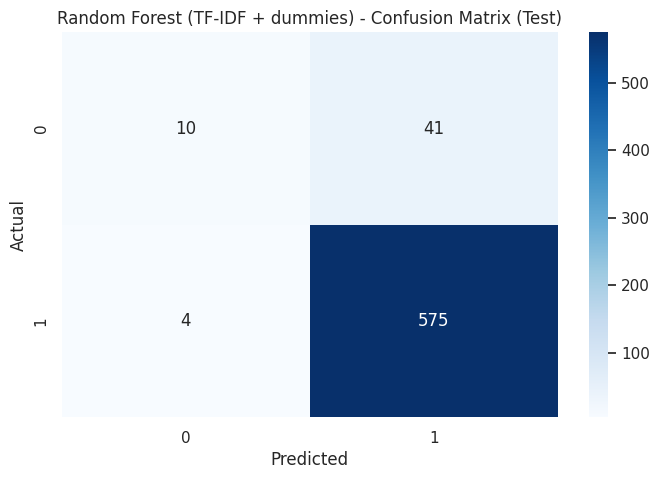

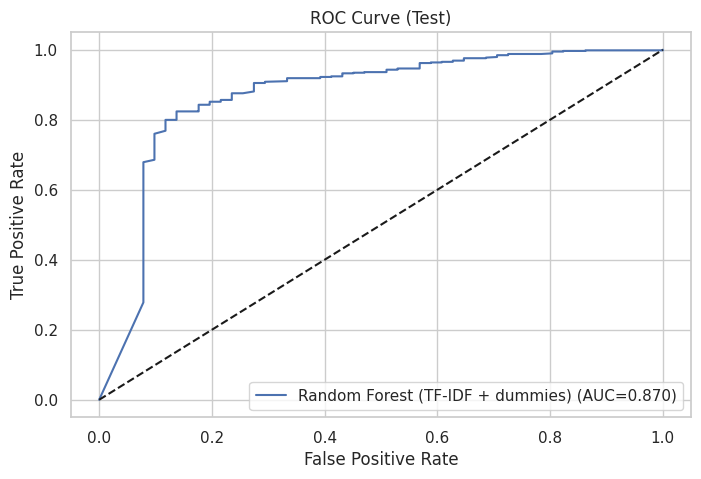

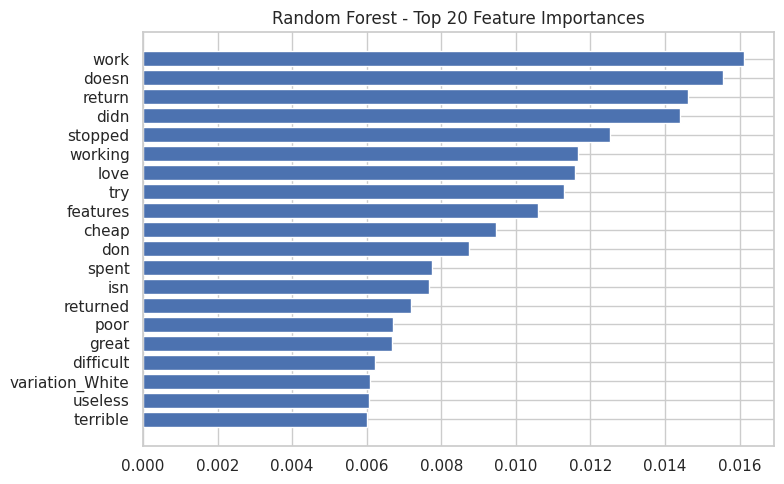

Sample prediction: 1
Torch device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: adedamolaogundipe11 (adedamolaogundipe11-willis-college-your-career-is-waiting-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,0.258900
200,0.161200
300,0.100800


BERT eval metrics: {'eval_loss': 0.1416165977716446, 'eval_accuracy': 0.9587301587301588, 'eval_precision': 0.9616026711185309, 'eval_recall': 0.9948186528497409, 'eval_f1': 0.9779286926994907, 'eval_roc_auc': 0.9778692133157234, 'eval_runtime': 269.824, 'eval_samples_per_second': 2.335, 'eval_steps_per_second': 0.074, 'epoch': 2.0}

BERT classification report (test):
              precision    recall  f1-score   support

           0     0.9032    0.5490    0.6829        51
           1     0.9616    0.9948    0.9779       579

    accuracy                         0.9587       630
   macro avg     0.9324    0.7719    0.8304       630
weighted avg     0.9569    0.9587    0.9540       630



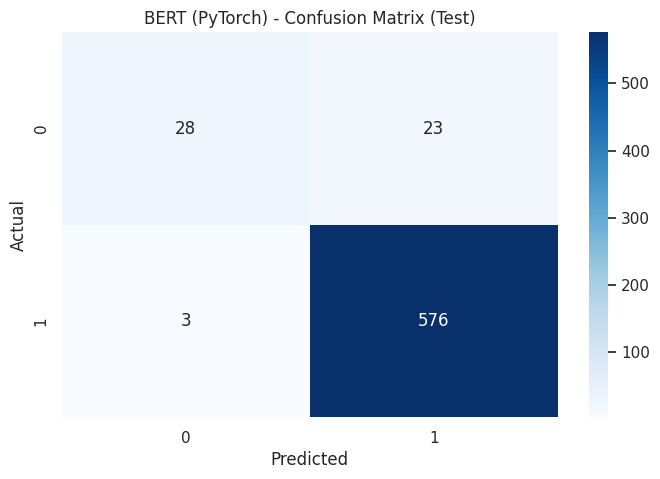

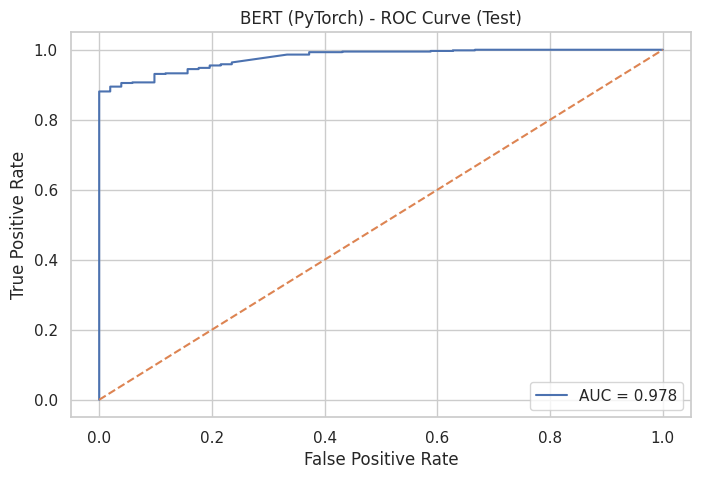